## Intializing stuff

In [1]:
!pwd

'pwd' is not recognized as an internal or external command,
operable program or batch file.


In [2]:
!which python

'which' is not recognized as an internal or external command,
operable program or batch file.


In [3]:
import pickle
import pygame
import numpy as np
from tqdm import tqdm
from typing import List, Any

from gymnasium import Env
from gymnasium import spaces
from gymnasium.utils import env_checker

pygame 2.1.2 (SDL 2.0.18, Python 3.8.13)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [4]:
# Display set up
import os
import time
import matplotlib.pyplot as plt
from IPython.display import clear_output


os.environ["SDL_VIDEODRIVER"] = "dummy"

## Define the agent

### Q-Learning

In [5]:
class QLearningAgent:
  def __init__(self, env: Env, doubleq: bool = False):
    """
    Args:
      env (Env): The environment the agent should act in.
      doubleq (bool): Whether to use double Q-Learning.
    """
    # Intialize Q-Table
    self.env = env
    self.doubleq = doubleq

    num_actions = env.action_space.n

    # To allow usage of this agent with the stock trading env
    if isinstance(env.observation_space, spaces.Dict):
      num_states = (env.observation_space['agent'].high+1).prod()
    else:
      num_states = env.observation_space.n

    # Intialize 2 Q tables if `doubleq` is True
    # Indexed as part, q_a/q_b, states, actions
    if doubleq: q_table_shape = (2, 2, num_states, num_actions)
    else: q_table_shape = (2, num_states, num_actions)

    self._q_table = np.zeros((
      q_table_shape
    ))

  @property
  def q_table(self) -> np.ndarray:
    return self._q_table

  @q_table.setter
  def q_table(self, path_to_q_table: str):
    with open(path_to_q_table, 'rb') as f:
      q_table = pickle.load(f)

    # Check if the table is compatible
    if self.q_table.shape != q_table.shape:
      raise ValueError("Trying to load incompatible Q-Table.")

    self._q_table = q_table

  def greedy_policy(self, state, part):
    if self.doubleq:
      # Choose the best action after taking the mean value of
      # the actions accross both tables.
      return self.q_table[part].mean(axis=0)[state].argmax()

    else: return self.q_table[part, state].argmax()

  def ep_greedy_policy(self, state, part, epsilon):
    random_num = self.env.np_random.uniform(0, 1)

    if random_num > epsilon:
      return self.greedy_policy(state, part)

    else:
      return self.env.action_space.sample()

  def _get_state_idx(self, observation: Any) -> int:
    """Helper func to allow the same Agent to be used with the stock
    prediction env.
    """
    if isinstance(observation, dict): state = observation['agent']
    else: state = observation

    # Convert 2-d state index to flat index
    # flat_idx = curr_row*num_cols+curr_col
    if isinstance(state, np.ndarray): 
      return state[0] * self.env.size + state[1]
    else:
      return state  

  def step(self, observation):
    state = self._get_state_idx(observation)
    # Check if all rewards were collected
    if (observation['reward']>0).sum() > 1:
      return self.greedy_policy(state, 0)
    else:
      return self.greedy_policy(state, 1)

  def save_pretrained(self, path_to_q_table: str):
    with open(path_to_q_table, 'wb') as f:
      pickle.dump(self.q_table, f)


## Define the Trainers

### Q-Learning Trainer

In [6]:
class QLearningTrainer:
    def __init__(self, agent: QLearningAgent):
        self.agent = agent

    def train(
        self,
        num_episodes: int = 10**5,
        lr: float = .4,
        gamma: float = .9,
        ep_min: float = .08,
        ep_max: float = 1.,
        decay_rate: float = .0008
    ) -> List[float]:
        """Train the agent

        Args:
        num_episodes (int, optional): Defaults to 10**5.
        lr (float, optional): The learning rate. Defaults to .4.
        gamma (float, optional): The discount factor. Defaults to .9.
        ep_min (float, optional): Min exploration probability. Defaults to .08.
        ep_max (float, optional): Max exploration probability. Defaults to 1.
        decay_rate (float, optional): Epsilon decay rate. Defaults to .0008.

        Returns:
        List[float]: Reward earned in every episode.
        """
        reward_history: List[float] = list()
        for episode in tqdm(range(num_episodes)):
            epsilon = ep_min + (ep_max-ep_min)*np.exp(-decay_rate*episode)

            total_reward = 0
            obs, _ = self.agent.env.reset(seed=88)
            state = self.agent._get_state_idx(obs)
            terminated, truncated = False, False

            # Run the episode
            while not (terminated or truncated):
                # Check if all rewards were collected
                if (obs['reward']>0).sum() > 1: part = 0
                else: part = 1

                action = self.agent.ep_greedy_policy(state, part, epsilon)

                obs, reward, terminated, truncated, _ = self.agent.env.step(action)
                new_state = self.agent._get_state_idx(obs)

                total_reward += reward

                # Update the Q table
                next_state_qvalue = self.agent.q_table[part, new_state].max()

                self.agent.q_table[part, state, action] += lr * \
                (reward+gamma*next_state_qvalue-self.agent.q_table[part, state, action])

                state = new_state

            reward_history.append(total_reward)

        return reward_history

    def evaluate(self, num_episodes: int = 10**2) -> List[float]:
        """Evaluate the agent

        Args:
            num_episodes (int): Defaults to 10**2.

        Returns:
            List[float]: Reward earned in every episode.
        """
        reward_history: List[float] = list()
        for _ in tqdm(range(num_episodes)):
            total_reward = 0
            obs, _ = self.agent.env.reset(seed=88)
            terminated, truncated = False, False

            # Run the episode
            while not (terminated or truncated):
                action = self.agent.step(obs)

                obs, reward, terminated, truncated, _ = self.agent.env.step(action)

                total_reward += reward

            reward_history.append(total_reward)

        return reward_history


### Double Q-Learning Trainer 

In [7]:
class DoubleQTrainer(QLearningTrainer):
    def __init__(self, agent: QLearningAgent):
        assert agent.doubleq, "The agent passed isn't configured for Double Q "\
            "learning"
        super().__init__(agent)

    def train(
        self,
        num_episodes: int = 10**5,
        lr: float = .4,
        gamma: float = .9,
        ep_min: float = .08,
        ep_max: float = 1.,
        decay_rate: float = .0008
    ) -> List[float]:
        """Train the agent

        Args:
        num_episodes (int, optional): Defaults to 10**5.
        lr (float, optional): The learning rate. Defaults to .4.
        gamma (float, optional): The discount factor. Defaults to .9.
        ep_min (float, optional): Min exploration probability. Defaults to .08.
        ep_max (float, optional): Max exploration probability. Defaults to 1.
        decay_rate (float, optional): Epsilon decay rate. Defaults to .0008.

        Returns:
        List[float]: Reward earned in every episode.
        """
        reward_history: List[float] = list()
        for episode in tqdm(range(num_episodes)):
            epsilon = ep_min + (ep_max-ep_min)*np.exp(-decay_rate*episode)

            total_reward = 0
            obs, _ = self.agent.env.reset(seed=88)
            state = self.agent._get_state_idx(obs)
            terminated, truncated = False, False

            # Run the episode
            while not (terminated or truncated):
                action = self.agent.ep_greedy_policy(state, epsilon)

                obs, reward, terminated, truncated, _ = self.agent.env.step(action)
                new_state = self.agent._get_state_idx(obs)

                total_reward += reward

                # Choose the table to update
                upd_idx = self.agent.env.np_random.choice([0, 1])
                eval_idx = 1-upd_idx

                # Update the Q table
                next_state_qvalue = self.agent.q_table[
                    eval_idx,
                    new_state,
                    self.agent.q_table[upd_idx, new_state].argmax()
                ]

                self.agent.q_table[upd_idx, state, action] += lr * \
                (reward+gamma*next_state_qvalue-self.agent.q_table[upd_idx, state, action])

                state = new_state

            reward_history.append(total_reward)

        return reward_history


## Build Determinisitic Grid Env

### Rules:
- Each square has a randomly assigned reward between -0.5 to 0.5. The goal has a reward of 1.0
- The size of the cactus/lemonade is indicative of the reward.
- Landing on a square causes the reward on that square to be consumed. i.e. landing on that square again will yield no reward (0 reward).

In [8]:
class DeterministicGridEnvironment(Env):
    metadata = {
        "render_modes": ["human", "rgb_array"],
        "render_fps": 4,
        "background_img": "./assets/background.jpg",
        "goal_img": "./assets/goal.png",
        "agent_img": "./assets/agent.png",
        "reward_img": "./assets/reward.png",
        "neg_reward_img": "./assets/neg_reward.png" 
    }

    def __init__(
        self,
        size: int = 4,
        max_time_steps:int = 20,
        render_mode=None,
        seed=88
    ):
        # Seed the random number generator
        super().reset(seed=seed)
        self.size = size
        self.observation_space = spaces.Dict(
            {
                "agent": spaces.Box(0, size - 1, shape=(2, ), seed=self.np_random, dtype=int),
                "goal": spaces.Box(0, size - 1, shape=(2, ), seed=self.np_random, dtype=int),
                # Randomly distribute rewards between -.5 to .5
                # (have an initial upperbound of 1. as that is the goal reward, then set the
                # non goal rewards > .5 as .5)
                "reward": spaces.Box(
                    -1., 1.,
                    shape=(size**2, ),
                    seed=self.np_random,
                    dtype=np.float16
                )
            }
        )

        self.action_space = spaces.Discrete(4)
        self.action_mode_space = spaces.Discrete(3)
        self.max_timesteps = max_time_steps

        self._base_states = np.zeros((size, size), dtype=np.float16)

        # Add 2 negative rewards
        for _ in range(2):
            neg_reward_loc = self.observation_space['agent'].sample()
            while self._base_states[tuple(neg_reward_loc)] != 0:
                neg_reward_loc = self.observation_space['agent'].sample()

            self._base_states[tuple(neg_reward_loc)] = -.5

        # Add 4 positive rewards
        for _ in range(4):
            pos_reward_loc = self.observation_space['agent'].sample()
            while self._base_states[tuple(pos_reward_loc)] != 0:
                pos_reward_loc = self.observation_space['agent'].sample()

            self._base_states[tuple(pos_reward_loc)] = .5

        """The following dictionary maps abstract actions from `self.action_space` to
        the direction we will walk in if that action is taken.
        I.e. 0 corresponds to "right", 1 to "up" etc.
        """
        self._action_to_direction = {
            0: {'move': np.array([1, 0]), 'name': 'down'},
            1: {'move': np.array([-1, 0]), 'name': 'up'},
            2: {'move': np.array([0, 1]), 'name': 'right'},
            3: {'move': np.array([0, -1]), 'name': 'left'},
        }

        self.timestep = 0
        self.states = self._base_states.copy()
        # We will sample the goals's location randomly until it does not coincide
        # with the reward locations.
        self._goal_pos = self.observation_space['goal'].sample()
        while self.states[tuple(self._goal_pos)] != 0:
            self._goal_pos = self.observation_space['goal'].sample()

        self.states[tuple(self._goal_pos)] = self.observation_space['reward'].high[0]

        # We will sample the agent's location randomly until it does not coincide
        # with the goal and reward locations.
        self._agent_pos = self.observation_space['agent'].sample()
        while self.states[tuple(self._agent_pos)] != 0:
            self._agent_pos = self.observation_space['agent'].sample()

        # Check for render mode legality
        assert render_mode is None or render_mode in self.metadata["render_modes"]
        self.render_mode = render_mode

        self.window = None
        self.clock = None
        self.window_size = 744  # The size of the PyGame window

    def reset(self, seed=None, options=None):
        # For compliance
        super().reset(seed=seed)

        # Reset env
        self.timestep = 0
        self.states = self._base_states.copy()
        self.states[tuple(self._goal_pos)] = self.observation_space['reward'].high[0]

        # Agent start pos changes everytime
        self._agent_pos = self.observation_space['agent'].sample()
        while self.states[tuple(self._agent_pos)] != 0:
            self._agent_pos = self.observation_space['agent'].sample()

        observation = self._get_obs()
        info = self._get_info()

        if self.render_mode == "human":
            self._render_frame()

        return observation, info

    def step(self, action):
        direction = self._action_to_direction[action]['move']
        
        # Restricting the agent to the grid.
        new_pos = np.clip(
            self._agent_pos + direction,
            0, self.size - 1
        )

        # Penalize reaching the goal before collecting all rewards
        block_exit = (self.states > 0).sum() > 1

        terminated = False
        if np.array_equal(new_pos, self._goal_pos):
            if block_exit:
                new_pos = self._agent_pos
            else:
                terminated = True

        # Give negative reward for actions that keep you in the same
        # place (boundary actions)
        if np.array_equal(self._agent_pos, new_pos):
            reward = self.observation_space['reward'].low[0]
        else: reward = self.states[tuple(new_pos)]

        # In all cases add a reward penalty of max negative reward
        # in other words, every action is penalized.
        reward += self.observation_space['reward'].low[0]

        self._agent_pos = new_pos

        # Record the action taken
        observation = self._get_obs()

        # Consume reward
        self.states[tuple(self._agent_pos)] = 0        
        
        # An episode is done iff the agent has reached the goal
        self.timestep += 1

        truncated = self.timestep > self.max_timesteps

        info = self._get_info()
        info.update({
            'action': self._action_to_direction[action]['name'] 
        })

        if self.render_mode == "human":
            self._render_frame()

        return observation, reward, terminated, truncated, info

    def _get_obs(self):
        return {
            "agent": self._agent_pos,
            "goal": self._goal_pos,
            "reward": self.states.flatten()
        }

    # City block distance between goal and agent
    def _get_info(self):
        return {
            "distance": np.linalg.norm(
                self._agent_pos - self._goal_pos, ord=1
            )
        }

    def render(self):
        if self.render_mode == "rgb_array":
            return self._render_frame()

    def _render_frame(self):
        if self.window is None and self.render_mode == "human":
            pygame.init()
            pygame.display.init()
            self.window = pygame.display.set_mode(
                (self.window_size, self.window_size)
            )
        if self.clock is None and self.render_mode == "human":
            self.clock = pygame.time.Clock()

        canvas = pygame.Surface((self.window_size, self.window_size))
        pix_square_size = (
            self.window_size / self.size
        )  # The size of a single grid square in pixels

        # Background image
        bg_img = pygame.image.load(self.metadata['background_img'])
        bg_img.set_alpha(188)
        bg_img = pygame.transform.scale(bg_img, (self.window_size, self.window_size))
        canvas.blit(
            bg_img,
            [0, 0]
        )

        # Goal image
        goal_img = pygame.image.load(self.metadata['goal_img'])
        goal_img = pygame.transform.scale(goal_img, (pix_square_size, pix_square_size))
        canvas.blit(
            goal_img,
            pix_square_size * self._goal_pos[::-1]
        )

        # Agent image
        agent_img = pygame.image.load(self.metadata['agent_img'])
        agent_img = pygame.transform.scale(agent_img, (pix_square_size, pix_square_size))
        canvas.blit(
            agent_img,
            pix_square_size * self._agent_pos[::-1]
        )

        # Reward image
        reward_img = pygame.image.load(self.metadata['reward_img'])
        # Negative reward image
        neg_reward_img = pygame.image.load(self.metadata['neg_reward_img'])

        # Add the reward and neg reward
        for x in range(self.size):
            for y in range(self.size):
                reward = self.states[x, y]
                if self.states[x, y] > 0 and self.states[x, y] < 1:
                    sreward_img = pygame.transform.scale(
                        reward_img,
                        (pix_square_size*reward, pix_square_size*reward)
                    )
                    rew_sz = np.array(sreward_img.get_size()) # w x h
                    position = pix_square_size * (np.array([y, x])+0.5)
                    # To center to grid square
                    position -= rew_sz[::-1] / 2
                    canvas.blit(
                        sreward_img,
                        position
                    )
                elif self.states[x, y] < 0:
                    reward *= -1
                    sneg_reward_img = pygame.transform.scale(
                        neg_reward_img,
                        (pix_square_size*reward, pix_square_size*reward)
                    )
                    nrew_sz = np.array(sneg_reward_img.get_size()) # w x h
                    position = pix_square_size * (np.array([y, x])+0.5)
                    # To center to grid square
                    position -= nrew_sz[::-1] / 2
                    canvas.blit(
                        sneg_reward_img,
                        position
                    )

        # Finally, add some gridlines
        for x in range(self.size + 1):
            pygame.draw.line(
                canvas,
                (255, 255, 255),
                (0, pix_square_size * x),
                (self.window_size, pix_square_size * x),
                width=2,
            )
            pygame.draw.line(
                canvas,
                (255, 255, 255),
                (pix_square_size * x, 0),
                (pix_square_size * x, self.window_size),
                width=2,
            )

        if self.render_mode == "human":
            # The following line copies our drawings from `canvas` to the visible window
            self.window.blit(canvas, canvas.get_rect())
            pygame.event.pump()
            pygame.display.update()

            # We need to ensure that human-rendering occurs at the predefined framerate.
            # The following line will automatically add a delay to keep the framerate stable.
            self.clock.tick(self.metadata["render_fps"])
        else:  # rgb_array
            return np.transpose(
                np.array(pygame.surfarray.pixels3d(canvas)), axes=(1, 0, 2)
            )

    def close(self):
        if self.window is not None:
            pygame.display.quit()
            pygame.quit()

In [9]:
# Initialize the agent and the env
denv = DeterministicGridEnvironment(size=6, render_mode='rgb_array', max_time_steps=40)

# Check for API Compliance
env_checker.check_env(denv)

## Train the Q-Learning Agent

In [10]:
num_episodes = 10**7
lr = .4
gamma = 0.95
ep_min = .08
ep_max = 1.
decay_rate = 8e-4

qlearning_agent = QLearningAgent(denv)
qtrainer = QLearningTrainer(qlearning_agent)
tr_q_history = qtrainer.train(num_episodes=num_episodes, gamma=gamma)

 14%|█▍        | 1407519/10000000 [6:28:16<39:30:20, 60.42it/s]     


KeyboardInterrupt: 

In [ ]:
# Save the Q Table
qlearning_agent.save_pretrained('./q-table-det.pkl')

# The q table can be loaded from the pkl file by uncommenting the below line
# qlearning_agent.q_table = './q-table-sto.pkl'

In [11]:
plt.rcParams["figure.figsize"] = (20,20)
plt.rcParams["font.size"] = 22

step = int(num_episodes/50)
plt.plot(range(0, num_episodes, step), tr_q_history[::step], label='Cumulative Reward per Episode', linewidth=2)
plt.plot([ep_min+(ep_max-ep_min)*np.exp(-decay_rate*i) for i in range(num_episodes)], label='Explore Probability (Epsilon)')
plt.xlabel("Episode Number")
plt.grid(True)
plt.legend()
plt.show()

NameError: name 'tr_q_history' is not defined

### Evaluate the Agent

In [12]:
num_eval_episodes = 10**3
ev_q_history = qtrainer.evaluate(num_episodes=num_eval_episodes)

100%|██████████| 1000/1000 [00:03<00:00, 308.55it/s]


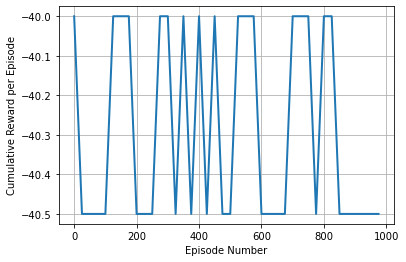

In [13]:
plt.rcParams["figure.figsize"] = (20,20)
plt.rcParams["font.size"] = 22

plt.plot(range(0, num_eval_episodes, 25), ev_q_history[::25],  linewidth=2)
plt.ylabel('Cumulative Reward per Episode')
plt.xlabel("Episode Number")
plt.grid(True)
plt.show()

### Display Learned Policy

In [14]:
# Part 1
learned_policy = [denv._action_to_direction[qlearning_agent.q_table[0][i].argmax()]['name']
                  for i in range(qlearning_agent.q_table[0].shape[0])]


learned_policy = np.array(learned_policy).reshape((denv.size, denv.size))

print(learned_policy)

[['right' 'down' 'left' 'down' 'left' 'left']
 ['right' 'down' 'left' 'left' 'down' 'down']
 ['down' 'left' 'left' 'left' 'left' 'left']
 ['up' 'down' 'up' 'up' 'left' 'up']
 ['up' 'left' 'up' 'left' 'right' 'up']
 ['right' 'right' 'up' 'left' 'left' 'up']]


In [15]:
# Part 2
learned_policy = [denv._action_to_direction[qlearning_agent.q_table[1][i].argmax()]['name']
                  for i in range(qlearning_agent.q_table[1].shape[0])]


learned_policy = np.array(learned_policy).reshape((denv.size, denv.size))

print(learned_policy)

[['down' 'down' 'down' 'down' 'down' 'down']
 ['down' 'down' 'down' 'down' 'up' 'down']
 ['down' 'down' 'down' 'down' 'left' 'left']
 ['right' 'down' 'left' 'left' 'left' 'left']
 ['up' 'up' 'up' 'down' 'right' 'down']
 ['up' 'up' 'left' 'up' 'right' 'down']]


### Take the env for a spin

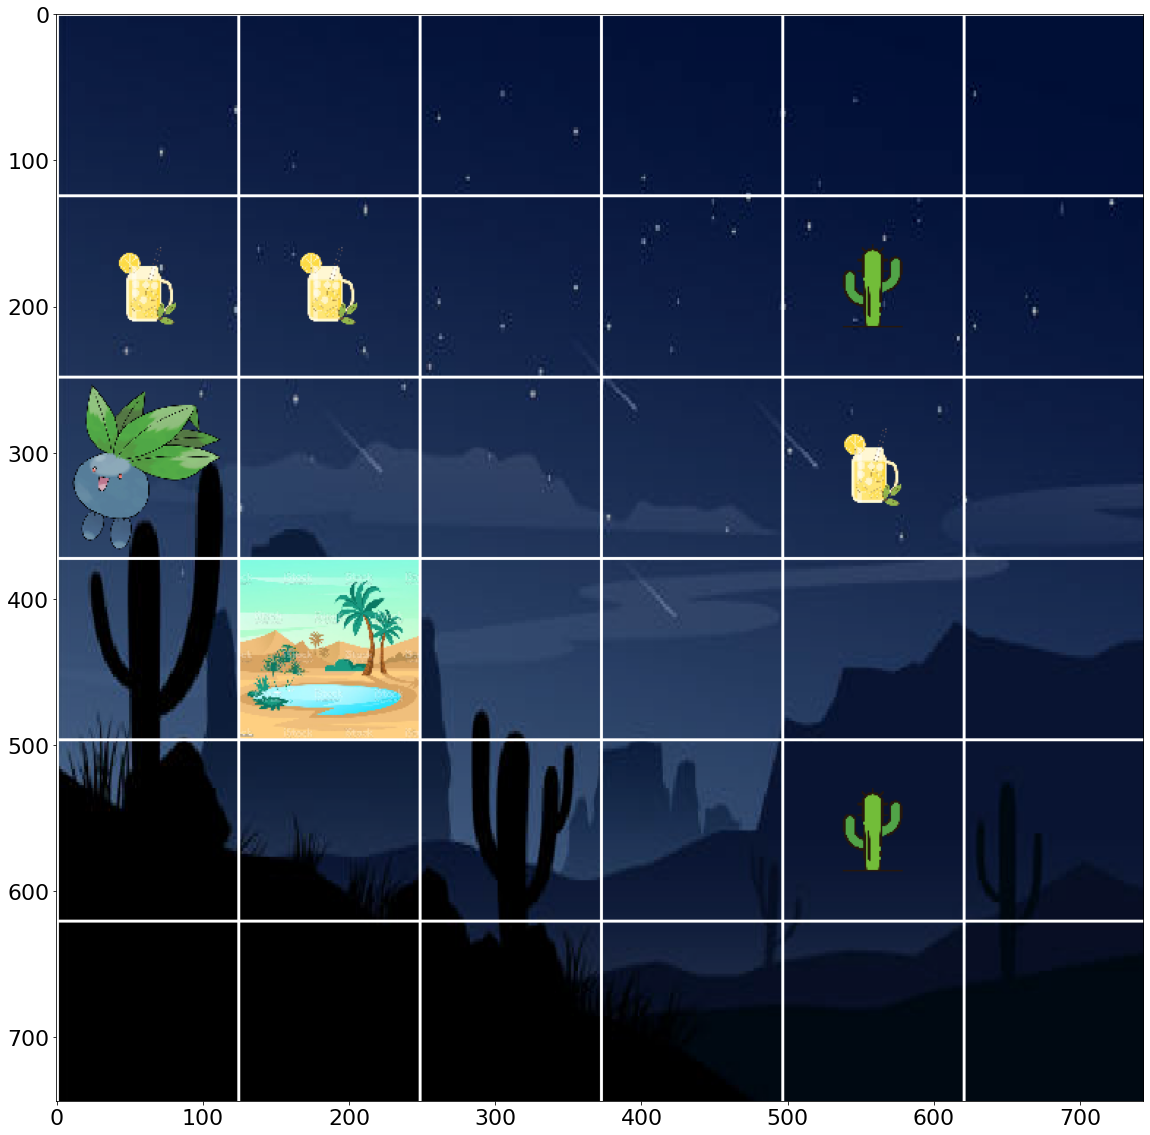

In [16]:
plt.rcParams["figure.figsize"] = (20,20)
plt.rcParams["font.size"] = 22

obs, info = denv.reset(seed=88)

terminated, truncated = False, False

plt.imshow(denv.render())
plt.show()

ep_history = [({k: obs[k] for k in set(list(obs.keys())) - {'reward'}}, info)]
while not (terminated or truncated):
  action = qlearning_agent.step(obs)
  obs, reward, terminated, truncated, info = denv.step(action)

  clear_output(wait=True)
  plt.imshow(denv.render())
  plt.show()

  ep_history.append((
    {k: obs[k] for k in set(list(obs.keys())) - {'reward'}},
    info, reward))
  time.sleep(1)

In [ ]:
# End the simulation
for item in ep_history:
    print(item)

denv.close()

## Train the Double Q-Learning Agent

In [ ]:
num_episodes = 10**5
lr = .4
gamma = 0.95
ep_min = .08
ep_max = 1.
decay_rate = 8e-4

dqlearning_agent = QLearningAgent(denv, doubleq=True)
dqtrainer = DoubleQTrainer(dqlearning_agent)
tr_dq_history = dqtrainer.train(num_episodes=num_episodes, gamma=gamma)

In [ ]:
# Save the Q Table
dqlearning_agent.save_pretrained('./doubleq-table-det.pkl')

# The q table can be loaded from the pkl file by uncommenting the below line
# dqlearning_agent.q_table = './doubleq-table-sto.pkl'

In [ ]:
plt.rcParams["figure.figsize"] = (20,20)
plt.rcParams["font.size"] = 22

step = int(num_episodes/50)
plt.plot(range(0, num_episodes, step), tr_dq_history[::step], label='Cumulative Reward per Episode', linewidth=2)
plt.plot([ep_min+(ep_max-ep_min)*np.exp(-decay_rate*i) for i in range(num_episodes)], label='Explore Probability (Epsilon)')
plt.xlabel("Episode Number")
plt.grid(True)
plt.legend()
plt.show()

### Evaluate the Agent

In [ ]:
num_eval_episodes = 10**3
ev_dq_history = dqtrainer.evaluate(num_episodes=num_eval_episodes)

In [ ]:
plt.rcParams["figure.figsize"] = (20,20)
plt.rcParams["font.size"] = 22

plt.plot(range(0, num_eval_episodes, 25), ev_dq_history[::25],  linewidth=2)
plt.ylabel('Cumulative Reward per Episode')
plt.xlabel("Episode Number")
plt.grid(True)
plt.show()

### Display Learned Policy

In [ ]:
# Take the mean of each states action-value estimates
mean_q_table =  dqlearning_agent.q_table.mean(axis=0)
learned_policy = [denv._action_to_direction[mean_q_table[i].argmax()]['name']
                  for i in range(mean_q_table.shape[0])]


learned_policy = np.array(learned_policy).reshape((denv.size, denv.size))

print(learned_policy)

### Take the env for a spin

In [ ]:
plt.rcParams["figure.figsize"] = (20,20)
plt.rcParams["font.size"] = 22

obs, info = denv.reset(seed=88)

terminated, truncated = False, False

plt.imshow(denv.render())
plt.show()

ep_history = [({k: obs[k] for k in set(list(obs.keys())) - {'reward'}}, info)]
while not (terminated or truncated):
  action = dqlearning_agent.step(obs)
  obs, reward, terminated, truncated, info = denv.step(action)

  clear_output(wait=True)
  plt.imshow(denv.render())
  plt.show()

  ep_history.append((
    {k: obs[k] for k in set(list(obs.keys())) - {'reward'}},
    info, reward))
  time.sleep(1)

In [ ]:
# End the simulation
for item in ep_history:
    print(item)

denv.close()

## Training Performance Evaluation

In [ ]:
plt.rcParams["figure.figsize"] = (20,20)
plt.rcParams["font.size"] = 22

step = int(num_episodes/50)
plt.plot(range(0, num_episodes, step), tr_dq_history[::step], label='Double Q-Learning', linewidth=2)
plt.plot(range(0, num_episodes, step), tr_q_history[::step], label='Q-Learning', linewidth=2)
plt.xlabel("Episode Number")
plt.ylabel("Cumulative Reward per Episode")
plt.grid(True)
plt.legend()

## Build a Stocastic Grid Env

### Rules:
- Landing on a square causes the reward on that square to be consumed. i.e. landing on that square again will yield no reward (0 reward).
- Whenever you perform an action there is a 2/3rd chance that the action is as you expect it to be, a 2/9th chance that it is the double of what you want it to be and a 1/9th chance of it being a mirror action.
- The reward (and negative reward) for each state is distributed in a reciprocal fashion. i.e. 1/9th the reward when coming through the expected action, 2/9th reward when coming via the opposite action and 2/3rd reward when coming via a mirror action. 

For instance on a 5x5 grid where the reward on each square is 1 (for simplicity):

If `s = (2,3)` and `a = RIGHT`:
-   2/3rd chance `s' = (2,4)` and `r = 1/9`
-   2/9th chance `s' = (2,5)` and `r = 2/9`
-   2/3rd chance `s' = (3,2)` and `r = 2/3`

Exception: Landing on the `goal` square will always yield a maximal reward (of 1 for the above example) regardless of how you get there.

In [ ]:
class StocasticGridEnvironment(Env):
    metadata = {
        "render_modes": ["human", "rgb_array"],
        "render_fps": 4,
        "background_img": "./assets/background.jpg",
        "goal_img": "./assets/goal.png",
        "agent_img": "./assets/agent.png",
        "reward_img": "./assets/reward.png",
        "neg_reward_img": "./assets/neg_reward.png" 
    }

    def __init__(
        self,
        size: int = 4,
        max_time_steps:int = 20,
        render_mode=None,
        seed=88
    ):
        super().reset(seed=seed)
        self.size = size
        self.observation_space = spaces.Dict(
            {
                "agent": spaces.Box(0, size - 1, shape=(2, ), seed=self.np_random, dtype=int),
                "goal": spaces.Box(0, size - 1, shape=(2, ), seed=self.np_random, dtype=int),
                # Randomly distribute rewards between -.5 to .5
                # (have an initial upperbound of 1. as that is the goal reward, then set the
                # non goal rewards > .5 as .5)
                "reward": spaces.Box(
                    -1., 1.,
                    shape=(size**2, ),
                    seed=self.np_random,
                    dtype=np.float16
                )
            }
        )

        self.action_space = spaces.Discrete(4)
        self.action_mode_space = spaces.Discrete(3)
        self.max_timesteps = max_time_steps

        self._base_states = np.zeros((size, size), dtype=np.float16)

        # Add 2 negative rewards
        for _ in range(2):
            neg_reward_loc = self.observation_space['agent'].sample()
            while self._base_states[tuple(neg_reward_loc)] != 0:
                neg_reward_loc = self.observation_space['agent'].sample()

            self._base_states[tuple(neg_reward_loc)] = -.5

        # Add 4 positive rewards
        for _ in range(4):
            pos_reward_loc = self.observation_space['agent'].sample()
            while self._base_states[tuple(pos_reward_loc)] != 0:
                pos_reward_loc = self.observation_space['agent'].sample()

            self._base_states[tuple(pos_reward_loc)] = .5

        """The following dictionary maps abstract actions from `self.action_space` to
        the direction we will walk in if that action is taken.
        I.e. 0 corresponds to "right", 1 to "up" etc.
        """
        self._action_to_direction = {
            0: {'move': np.array([1, 0]), 'name': 'down'},
            1: {'move': np.array([-1, 0]), 'name': 'up'},
            2: {'move': np.array([0, 1]), 'name': 'right'},
            3: {'move': np.array([0, -1]), 'name': 'left'},
        }
        self._action_mode_mapping = {
            0: {'p': 2/3, 'name': 'as-is', 'score_mul': 1/9},
            1: {'p': 2/9, 'name': 'double', 'score_mul': 2/9},
            2: {'p': 1/9, 'name': 'mirror', 'score_mul': 2/3}
        }

        self.timestep = 0
        self.states = self._base_states.copy()
        # We will sample the goals's location randomly until it does not coincide
        # with the reward locations.
        self._goal_pos = self.observation_space['goal'].sample()
        while self.states[tuple(self._goal_pos)] != 0:
            self._goal_pos = self.observation_space['goal'].sample()

        self.states[tuple(self._goal_pos)] = self.observation_space['reward'].high[0]

        # We will sample the agent's location randomly until it does not coincide
        # with the goal and reward locations.
        self._agent_pos = self.observation_space['agent'].sample()
        while self.states[tuple(self._agent_pos)] != 0:
            self._agent_pos = self.observation_space['agent'].sample()

        # Check for render mode legality
        assert render_mode is None or render_mode in self.metadata["render_modes"]
        self.render_mode = render_mode

        self.window = None
        self.clock = None
        self.window_size = 744  # The size of the PyGame window

    def reset(self, seed=None, options=None):
        # For compliance
        super().reset(seed=seed)

        # Reset env
        self.timestep = 0
        self.states = self._base_states.copy()
        self.states[tuple(self._goal_pos)] = self.observation_space['reward'].high[0]

        # Agent start pos changes everytime
        self._agent_pos = self.observation_space['agent'].sample()
        while self.states[tuple(self._agent_pos)] != 0:
            self._agent_pos = self.observation_space['agent'].sample()

        observation = self._get_obs()
        info = self._get_info()

        if self.render_mode == "human":
            self._render_frame()

        return observation, info

    def step(self, action):
        # Randomly select the action mode
        action_mode = self.np_random.choice(
            range(self.action_mode_space.n),
            p=[self._action_mode_mapping[i]['p']
               for i in range(self.action_mode_space.n)]
        )

        if self._action_mode_mapping[action_mode]['name'] in ('double', 'as-is'):
            direction = self._action_to_direction[action]['move'].copy()
            if self._action_mode_mapping[action_mode]['name'] == 'double':
                direction *= 2

            # Restricting the agent to the grid.
            new_pos = np.clip(
                self._agent_pos + direction,
                0, self.size - 1
            )

        else:
            new_pos = self._agent_pos[::-1]

        # Give negative reward for actions that keep you in the same
        # place (boundary actions)
        if np.array_equal(self._agent_pos, new_pos):
            reward = self.observation_space['reward'].low[0]
        else: reward = self.states[tuple(new_pos)]

        self._agent_pos = new_pos

        # Record the action taken
        observation = self._get_obs()

        # Check if terminated
        if np.array_equal(self._agent_pos, self._goal_pos):
            reward = self.observation_space['reward'].high[0]
            terminated = True

        else:
            reward = np.round(self.states[tuple(self._agent_pos)] * 
                self._action_mode_mapping[action_mode]['score_mul'], 2)
            terminated = False

        # Consume reward
        self.states[tuple(self._agent_pos)] = 0
        
        # An episode is done iff the agent has reached the goal
        self.timestep += 1

        truncated = self.timestep > self.max_timesteps

        info = self._get_info()
        info.update({
            'action': self._action_to_direction[action]['name'],
            'action_mode': self._action_mode_mapping[action_mode]['name']
        })

        if self.render_mode == "human":
            self._render_frame()

        return observation, reward, terminated, truncated, info

    def _get_obs(self):
        return {
            "agent": self._agent_pos,
            "goal": self._goal_pos,
            "reward": self.states.flatten()
        }

    # City block distance between goal and agent
    def _get_info(self):
        return {
            "distance": np.linalg.norm(
                self._agent_pos - self._goal_pos, ord=1
            )
        }

    def render(self):
        if self.render_mode == "rgb_array":
            return self._render_frame()

    def _render_frame(self):
        if self.window is None and self.render_mode == "human":
            pygame.init()
            pygame.display.init()
            self.window = pygame.display.set_mode(
                (self.window_size, self.window_size)
            )
        if self.clock is None and self.render_mode == "human":
            self.clock = pygame.time.Clock()

        canvas = pygame.Surface((self.window_size, self.window_size))
        pix_square_size = (
            self.window_size / self.size
        )  # The size of a single grid square in pixels

        # Background image
        bg_img = pygame.image.load(self.metadata['background_img'])
        bg_img.set_alpha(188)
        bg_img = pygame.transform.scale(bg_img, (self.window_size, self.window_size))
        canvas.blit(
            bg_img,
            [0, 0]
        )

        # Goal image
        goal_img = pygame.image.load(self.metadata['goal_img'])
        goal_img = pygame.transform.scale(goal_img, (pix_square_size, pix_square_size))
        canvas.blit(
            goal_img,
            pix_square_size * self._goal_pos[::-1]
        )

        # Agent image
        agent_img = pygame.image.load(self.metadata['agent_img'])
        agent_img = pygame.transform.scale(agent_img, (pix_square_size, pix_square_size))
        canvas.blit(
            agent_img,
            pix_square_size * self._agent_pos[::-1]
        )

        # Reward image
        reward_img = pygame.image.load(self.metadata['reward_img'])
        # Negative reward image
        neg_reward_img = pygame.image.load(self.metadata['neg_reward_img'])

        # Add the reward and neg reward
        for x in range(self.size):
            for y in range(self.size):
                reward = self.states[x, y]
                if self.states[x, y] > 0 and self.states[x, y] < 1:
                    sreward_img = pygame.transform.scale(
                        reward_img,
                        (pix_square_size*reward, pix_square_size*reward)
                    )
                    rew_sz = np.array(sreward_img.get_size()) # w x h
                    position = pix_square_size * (np.array([y, x])+0.5)
                    # To center to grid square
                    position -= rew_sz[::-1] / 2
                    canvas.blit(
                        sreward_img,
                        position
                    )
                elif self.states[x, y] < 0:
                    reward *= -1
                    sneg_reward_img = pygame.transform.scale(
                        neg_reward_img,
                        (pix_square_size*reward, pix_square_size*reward)
                    )
                    nrew_sz = np.array(sneg_reward_img.get_size()) # w x h
                    position = pix_square_size * (np.array([y, x])+0.5)
                    # To center to grid square
                    position -= nrew_sz[::-1] / 2
                    canvas.blit(
                        sneg_reward_img,
                        position
                    )

        # Finally, add some gridlines
        for x in range(self.size + 1):
            pygame.draw.line(
                canvas,
                (255, 255, 255),
                (0, pix_square_size * x),
                (self.window_size, pix_square_size * x),
                width=2,
            )
            pygame.draw.line(
                canvas,
                (255, 255, 255),
                (pix_square_size * x, 0),
                (pix_square_size * x, self.window_size),
                width=2,
            )

        if self.render_mode == "human":
            # The following line copies our drawings from `canvas` to the visible window
            self.window.blit(canvas, canvas.get_rect())
            pygame.event.pump()
            pygame.display.update()

            # We need to ensure that human-rendering occurs at the predefined framerate.
            # The following line will automatically add a delay to keep the framerate stable.
            self.clock.tick(self.metadata["render_fps"])
        else:  # rgb_array
            return np.transpose(
                np.array(pygame.surfarray.pixels3d(canvas)), axes=(1, 0, 2)
            )

    def close(self):
        if self.window is not None:
            pygame.display.quit()
            pygame.quit()

In [ ]:
# Initialize the agent and the env
senv = StocasticGridEnvironment(size=6, render_mode='rgb_array')

# Check for API Compliance
env_checker.check_env(senv)

## Train the Q-Learning Agent

In [ ]:
num_episodes = 10**5
lr = .4
gamma = 0.95
ep_min = .08
ep_max = 1.
decay_rate = 8e-4

qlearning_agent = QLearningAgent(senv)
qtrainer = QLearningTrainer(qlearning_agent)
tr_q_history = qtrainer.train(num_episodes=num_episodes, gamma=gamma)

In [ ]:
# Save the Q Table
qlearning_agent.save_pretrained('./q-table-sto.pkl')

# The q table can be loaded from the pkl file by uncommenting the below line
# qlearning_agent.q_table = './q-table-sto.pkl'

In [ ]:
plt.rcParams["figure.figsize"] = (20,20)
plt.rcParams["font.size"] = 22

step = int(num_episodes/50)
plt.plot(range(0, num_episodes, step), tr_q_history[::step], label='Cumulative Reward per Episode', linewidth=2)
plt.plot([ep_min+(ep_max-ep_min)*np.exp(-decay_rate*i) for i in range(num_episodes)], label='Explore Probability (Epsilon)')
plt.xlabel("Episode Number")
plt.grid(True)
plt.legend()
plt.show()

### Evaluate the Agent

In [ ]:
num_eval_episodes = 10**3
ev_q_history = qtrainer.evaluate(num_episodes=num_eval_episodes)

In [ ]:
plt.rcParams["figure.figsize"] = (20,20)
plt.rcParams["font.size"] = 22

plt.plot(range(0, num_eval_episodes, 25), ev_q_history[::25],  linewidth=2)
plt.ylabel('Cumulative Reward per Episode')
plt.xlabel("Episode Number")
plt.grid(True)
plt.show()

### Display Learned Policy

In [ ]:
learned_policy = [senv._action_to_direction[qlearning_agent.q_table[i].argmax()]['name']
                  for i in range(qlearning_agent.q_table.shape[0])]


learned_policy = np.array(learned_policy).reshape((senv.size, senv.size))

print(learned_policy)

### Take the env for a spin

In [ ]:
plt.rcParams["figure.figsize"] = (20,20)
plt.rcParams["font.size"] = 22

obs, info = senv.reset(seed=88)

terminated, truncated = False, False

plt.imshow(senv.render())
plt.show()

ep_history = [({k: obs[k] for k in set(list(obs.keys())) - {'reward'}}, info)]
while not (terminated or truncated):
  action = qlearning_agent.step(obs)
  obs, reward, terminated, truncated, info = senv.step(action)

  clear_output(wait=True)
  plt.imshow(senv.render())
  plt.show()

  ep_history.append((
    {k: obs[k] for k in set(list(obs.keys())) - {'reward'}},
    info, reward))
  time.sleep(1)

In [ ]:
# End the simulation
for item in ep_history:
    print(item)

senv.close()

## Train the Double Q-Learning Agent

In [ ]:
num_episodes = 10**5
lr = .4
gamma = 0.95
ep_min = .08
ep_max = 1.
decay_rate = 8e-4

dqlearning_agent = QLearningAgent(senv, doubleq=True)
dqtrainer = DoubleQTrainer(dqlearning_agent)
tr_dq_history = dqtrainer.train(num_episodes=num_episodes, gamma=gamma)

In [ ]:
# Save the Q Table
dqlearning_agent.save_pretrained('./doubleq-table-sto.pkl')

# The q table can be loaded from the pkl file by uncommenting the below line
# dqlearning_agent.q_table = './doubleq-table-sto.pkl'

In [ ]:
plt.rcParams["figure.figsize"] = (20,20)
plt.rcParams["font.size"] = 22

step = int(num_episodes/50)
plt.plot(range(0, num_episodes, step), tr_dq_history[::step], label='Cumulative Reward per Episode', linewidth=2)
plt.plot([ep_min+(ep_max-ep_min)*np.exp(-decay_rate*i) for i in range(num_episodes)], label='Explore Probability (Epsilon)')
plt.xlabel("Episode Number")
plt.grid(True)
plt.legend()
plt.show()

### Evaluate the Agent

In [ ]:
num_eval_episodes = 10**3
ev_dq_history = dqtrainer.evaluate(num_episodes=num_eval_episodes)

In [ ]:
plt.rcParams["figure.figsize"] = (20,20)
plt.rcParams["font.size"] = 22

plt.plot(range(0, num_eval_episodes, 25), ev_dq_history[::25],  linewidth=2)
plt.ylabel('Cumulative Reward per Episode')
plt.xlabel("Episode Number")
plt.grid(True)
plt.show()

### Display Learned Policy

In [ ]:
# Take the mean of each states action-value estimates
mean_q_table =  dqlearning_agent.q_table.mean(axis=0)
learned_policy = [senv._action_to_direction[mean_q_table[i].argmax()]['name']
                  for i in range(mean_q_table.shape[0])]


learned_policy = np.array(learned_policy).reshape((senv.size, senv.size))

print(learned_policy)

### Take the env for a spin

In [ ]:
plt.rcParams["figure.figsize"] = (20,20)
plt.rcParams["font.size"] = 22

obs, info = senv.reset(seed=88)

terminated, truncated = False, False

plt.imshow(senv.render())
plt.show()

ep_history = [({k: obs[k] for k in set(list(obs.keys())) - {'reward'}}, info)]
while not (terminated or truncated):
  action = dqlearning_agent.step(obs)
  obs, reward, terminated, truncated, info = senv.step(action)

  clear_output(wait=True)
  plt.imshow(senv.render())
  plt.show()

  ep_history.append((
    {k: obs[k] for k in set(list(obs.keys())) - {'reward'}},
    info, reward))
  time.sleep(1)

In [ ]:
# End the simulation
for item in ep_history:
    print(item)

senv.close()

## Training Performance Evaluation

In [ ]:
plt.rcParams["figure.figsize"] = (20,20)
plt.rcParams["font.size"] = 22

step = int(num_episodes/50)
plt.plot(range(0, num_episodes, step), tr_dq_history[::step], label='Double Q-Learning', linewidth=2)
plt.plot(range(0, num_episodes, step), tr_q_history[::step], label='Q-Learning', linewidth=2)
plt.xlabel("Episode Number")
plt.ylabel("Cumulative Reward per Episode")
plt.grid(True)
plt.legend()